# Segmentation of Road from Satellite imagery

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip install tensorflow==1.14.0

import os
import cv2
#from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
from keras import backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py

seed = 56

     |████████████████████████████████| 109.2MB 35kB/s 
     |████████████████████████████████| 491kB 45.3MB/s 
     |████████████████████████████████| 3.2MB 58.6MB/s 
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


Using TensorFlow backend.


In [2]:
pip install -U segmentation-models

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/MapSegClean/"
%cd gdrive/My\ Drive/MapSegClean/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
/content/gdrive/My Drive/MapSegClean


## Defining Custom Loss functions and accuracy Metric.

In [0]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## Defining Our Model

In [5]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [6]:
model = Unet('efficientnetb7', input_shape=(256, 256, 3), encoder_weights=None, decoder_use_batchnorm=True)
#model = Unet(input_shape=(256, 256, 3), weights=None, activation='elu')
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 64) 0           stem

### On Test Images

In [0]:
model.load_weights("/content/gdrive/My Drive/MapSegClean/Models/Final_unet_efficientnetb7_road_weights.h5")

In [8]:
import cv2
import glob
import numpy as np
import h5py

#test_images = np.array([cv2.imread(file) for file in glob.glob("/home/bisag/Desktop/Road-Segmentation/I/")])
#test_masks = np.array([cv2.imread(file) for file in glob.glob("/home/bisag/Desktop/Road-Segmentation/M/")])
test_masks = []
test_images = []
files = glob.glob ("TestI/*.png")
for myFile in files:
    print(myFile)
    image = cv2.imread (myFile)
    test_images.append (image)
    myFile = 'TestM' + myFile[5:len(myFile)]
    image = cv2.cvtColor(cv2.imread (myFile), cv2.COLOR_BGR2GRAY)
    test_masks.append (image)


#files = glob.glob ("TestM/*.png")
#for myFile in files:
#    print(myFile)

    
#test_images = cv2.imread("/home/bisag/Desktop/Road-Segmentation/I/1.png")
#test_masks = cv2.imread("/home/bisag/Desktop/Road-Segmentation/M/1.png")

test_images = np.array(test_images)
test_masks = np.array(test_masks)

test_masks = np.expand_dims(test_masks, -1)
print("Unique elements in the train mask:", np.unique(test_masks))

print(test_images.shape)
print(test_masks.shape)


TestI/10378690_15_24.png
TestI/10378690_15_4.png
TestI/10228705_15_22.png
TestI/10378675_15_14.png
TestI/10078690_15_18.png
TestI/10228660_15_20.png
TestI/10378675_15_4.png
TestI/10078735_15_25.png
TestI/10228675_15_22.png
TestI/10078690_15_16.png
TestI/10228735_15_20.png
TestI/10078720_15_14.png
TestI/10378675_15_24.png
TestI/10378690_15_5.png
TestI/10078660_15_4.png
TestI/10228705_15_24.png
TestI/10228735_15_13.png
TestI/10228720_15_2.png
TestI/10378660_15_19.png
TestI/10378675_15_13.png
TestI/10228705_15_7.png
TestI/10228765_15_25.png
TestI/10228675_15_6.png
TestI/10228675_15_9.png
TestI/10228720_15_16.png
TestI/10228705_15_19.png
TestI/10228750_15_12.png
TestI/10078720_15_18.png
TestI/10228675_15_14.png
TestI/10228750_15_5.png
Unique elements in the train mask: [  0 255]
(30, 256, 256, 3)
(30, 256, 256, 1)


In [0]:
!pip list | grep cv

cvxopt                   1.2.4          
cvxpy                    1.0.28         
opencv-contrib-python    4.1.2.30       
opencv-python            4.1.2.30       


In [9]:
model.evaluate(test_images, test_masks)

RuntimeError: ignored

In [10]:
predictions = model.predict(test_images, verbose=1)*255

30/30 [==============================] - 27s 907ms/step


In [0]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

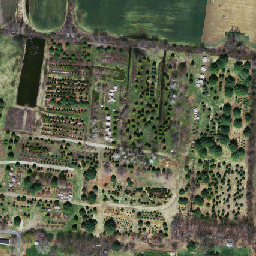

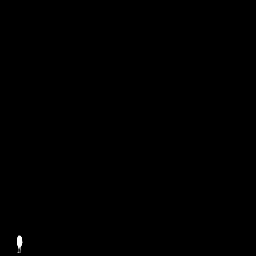

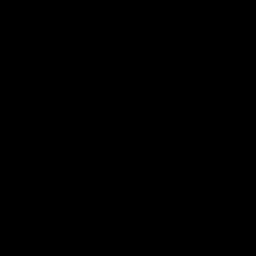

In [19]:
from google.colab.patches import cv2_imshow
cv2_imshow(np.squeeze(test_images[14]))
cv2_imshow(np.squeeze(predictions[14]))
cv2_imshow(np.squeeze(test_masks[14]))


In [20]:
import matplotlib

for i in range(len(predictions)):
    print(i)
    cv2.imwrite( "Results/" + str(i) + "Image.png"  , test_images[i])
    cv2.imwrite( "Results/" + str(i) + "GroundTruth.png"  , test_masks[i])
    #cv2.imwrite( "/home/bisag/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction.png"  , np.squeeze(predictions[i][:,:,0]))
    #cv2.imwrite( "/home/bisag/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction_Threshold.png"  , np.squeeze(predicton_threshold[i][:,:,0]))
    #matplotlib.image.imsave('/home/bisag/Desktop/Road-Segmentation/Results/000.png', np.squeeze(predicton_threshold[0][:,:,0]))
    matplotlib.image.imsave("Results/" + str(i) + "Prediction.png"  , np.squeeze(predictions[i][:,:,0]))
    matplotlib.image.imsave( "Results/" + str(i) + "Prediction_Threshold.png"  , np.squeeze(predicton_threshold[i][:,:,0]))

    #imshow(np.squeeze(predictions[0][:,:,0]))


#import scipy.misc
#scipy.misc.imsave('/home/bisag/Desktop/Road-Segmentation/Results/00.png', np.squeeze(predictions[0][:,:,0]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
